# Multi Class Image Classification

In image classification, we train a deep neural network to predict the labels/class of on what the image contains. In this project, we are building a model to classify the objects in the CIFAR-10 dataset which contains 50000 training images from 10 different classes.

First let's import the relevant packages and then download the dataset using the Kaggle API.

In [1]:
import os
import cv2
from numpy import asarray
import numpy as np
import glob2
from random import randint
import pandas as pd
from shutil import copyfile
import random


import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Input, Concatenate, concatenate, Dropout, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import keras.backend as K
import tensorflow_addons as tfa

Using TensorFlow backend.


In [2]:
!mkdir .kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammedsalihkgp","key":"a40055bd26eab67ac9aea2a2b1d16e5b"}'}

In [5]:
!mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c cifar-10

100% 610M/610M [00:11<00:00, 56.5MB/s]

  0% 0.00/575k [00:00<?, ?B/s]
100% 575k/575k [00:00<00:00, 36.0MB/s]
 92% 96.0M/105M [00:02<00:00, 44.3MB/s]
100% 105M/105M [00:02<00:00, 41.9MB/s] 
  0% 0.00/655k [00:00<?, ?B/s]
100% 655k/655k [00:00<00:00, 204MB/s]


Let's import the csv file into a pandas data frame.

In [9]:
labels_df = pd.read_csv('trainLabels.csv')

In [10]:
labels_df.iloc[2500]

id       2501
label     dog
Name: 2500, dtype: object

Now let's create a dictionary from the dataframe with the file name as keys and the corresponding class as its value.

In [11]:
dict_labels = {}

for i in range(labels_df.shape[0]):
  label = str(labels_df.iloc[i,0]) + '.png'
  dict_labels[label] = labels_df.iloc[i,1]

In [12]:
dataset = list(dict_labels.keys())

Now let's split the dataset into train, test and val sets.

In [13]:
random.shuffle(dataset)

In [14]:
n_train = 45000
n_val = 2500

train_set = dataset[:n_train]
val_set = dataset[n_train:n_train+n_val]
test_set = dataset[n_train+n_val:]

In [15]:
print(f'Train - {len(train_set)}, Val - {len(val_set)}, Test - {len(test_set)}')

Train - 45000, Val - 2500, Test - 2500


Now let's extract the images from its compressed format.

In [16]:
!pip install py7zr
!py7zr x train.7z

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 13.7MB 236kB/s 


Now let's arrange the images in the format required for Keras ImageDataGenerator.

In [17]:
loop_dict = {'train': train_set, 'val': val_set, 'test': test_set}

for folder in loop_dict.keys():
  for directory in labels_df['label'].unique():
    os.makedirs('/content/data/' + folder + '/' + directory)

In [18]:
for folder in loop_dict.keys():
  imgs = loop_dict[folder]
  for img in imgs:
    label_dir = dict_labels[img]
    src = "train/" + img
    dst = "data/" + folder + "/" + label_dir + "/" + img
    copyfile(src,dst)

Let's do a sanity check on whether the image directories are in order.

In [19]:
test_cat = glob2.glob('data/test/cat/*.png')

In [20]:
from PIL import Image

image = Image.open(test_cat[75])
print(image.size)
print(image.mode)

(32, 32)
RGB


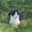

In [21]:
display(image)

In [22]:
image_np = np.array(image)
image_np.shape

(32, 32, 3)

Defining a datagen for the learning process.

In [23]:
datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input)

In [24]:
train_it = datagen.flow_from_directory('data/train/', batch_size=64, target_size = (32,32))
val_it = datagen.flow_from_directory('data/val/', batch_size=64, target_size = (32,32))
test_it = datagen.flow_from_directory('data/test/', batch_size=64, target_size = (32,32))

Found 45000 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [25]:
train_it.class_indices

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

Now let's try to use different network architectures for creating a model. First let's create a base model on top of the convolutional layers of a VGG 16 network trained on the imagenet dataset.

In [26]:
def base_network(lr = 0.001):
 
  base = Sequential()
  base.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    input_shape = (32,32,3),
    ))
  base.add(Dense(units=256,activation='relu'))
  base.add(Dense(units=64,activation='relu'))
  base.add(Dense(units=10,activation='softmax'))
  base.layers[0].trainable = False

  base.compile(keras.optimizers.Adam(lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return base

In [27]:
model = base_network()

58892288/58889256 [==============================] - 5s 0us/step


In [28]:
model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [29]:
from keras.callbacks import EarlyStopping

usualCallback = EarlyStopping(monitor='val_loss', min_delta=0, patience = 50)

In [30]:
model.fit(x= train_it, epochs = 20, validation_data = val_it, callbacks=[usualCallback])

Epoch 1/20
704/704 [==============================] - 28s 39ms/step - loss: 1.6423 - accuracy: 0.5374 - val_loss: 1.3534 - val_accuracy: 0.6152
Epoch 2/20
704/704 [==============================] - 21s 30ms/step - loss: 1.0069 - accuracy: 0.6545 - val_loss: 1.0966 - val_accuracy: 0.6364
Epoch 3/20
704/704 [==============================] - 21s 30ms/step - loss: 0.8782 - accuracy: 0.6947 - val_loss: 0.7079 - val_accuracy: 0.6484
Epoch 4/20
704/704 [==============================] - 21s 30ms/step - loss: 0.7899 - accuracy: 0.7254 - val_loss: 0.8330 - val_accuracy: 0.6540
Epoch 5/20
704/704 [==============================] - 21s 30ms/step - loss: 0.7138 - accuracy: 0.7499 - val_loss: 1.6050 - val_accuracy: 0.6608
Epoch 6/20
704/704 [==============================] - 21s 30ms/step - loss: 0.6415 - accuracy: 0.7733 - val_loss: 0.6975 - val_accuracy: 0.6424
Epoch 7/20
704/704 [==============================] - 21s 30ms/step - loss: 0.5750 - accuracy: 0.7975 - val_loss: 1.6991 - val_accuracy:

We can see that there is no improvement on val_accuracy over the epochs. It indicates that the network is not able to learn properly so that it can generalise on unseen data. Let's allow the model to update the weights of the CNN layers as well.

We will add a dropout layer as well.

In [31]:
def base_network_dropout(lr = 0.001):
 
  base = Sequential()
  base.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    input_shape = (32,32,3),
    ))
  base.add(Dense(units=256,activation='relu'))
  base.add(Dropout(0.2, seed = 3))
  base.add(Dense(units=64,activation='relu'))
  base.add(Dense(units=10,activation='softmax'))
  #base.layers[0].trainable = False

  base.compile(keras.optimizers.Adam(lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return base

In [32]:
model_drop = base_network_dropout()
model_drop.fit(x= train_it, epochs = 20, validation_data = val_it, callbacks=[usualCallback])

Epoch 1/20
704/704 [==============================] - 28s 40ms/step - loss: 2.0134 - accuracy: 0.2288 - val_loss: 1.9133 - val_accuracy: 0.3440
Epoch 2/20
704/704 [==============================] - 27s 38ms/step - loss: 1.4688 - accuracy: 0.4390 - val_loss: 2.6989 - val_accuracy: 0.5264
Epoch 3/20
704/704 [==============================] - 27s 39ms/step - loss: 1.1247 - accuracy: 0.5922 - val_loss: 0.6087 - val_accuracy: 0.6328
Epoch 4/20
704/704 [==============================] - 27s 38ms/step - loss: 0.9419 - accuracy: 0.6705 - val_loss: 0.2555 - val_accuracy: 0.6592
Epoch 5/20
704/704 [==============================] - 27s 38ms/step - loss: 0.8179 - accuracy: 0.7163 - val_loss: 0.3411 - val_accuracy: 0.6920
Epoch 6/20
704/704 [==============================] - 27s 38ms/step - loss: 0.7242 - accuracy: 0.7533 - val_loss: 0.6119 - val_accuracy: 0.7352
Epoch 7/20
704/704 [==============================] - 27s 39ms/step - loss: 0.6500 - accuracy: 0.7826 - val_loss: 1.4404 - val_accuracy:

We have got an increased performance. But as we can see, the model has an avoidable bias problem (training accuracy ~ 0.915) and also a high variance problem (i.e. overfitting). Let's try out a more complex network with more FC layers so that the bias problem can be reduced.

In [33]:
datagen_2 = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input)
train_it_2 = datagen.flow_from_directory('data/train/', batch_size=256, target_size = (32,32))

Found 45000 images belonging to 10 classes.


In [36]:
def base_network_2(lr = 0.001, vgg_pool = 'avg', drop1 = 0, drop2 = 0):
 
  base = Sequential()
  base.add(VGG16(
    include_top=False,
    pooling=vgg_pool,
    weights='imagenet',
    input_shape = (32,32,3),
    ))
  base.add(Dense(units=1024,activation='relu'))
  base.add(Dense(units=512,activation='relu'))
  base.add(Dense(units=256,activation='relu'))
  base.add(Dropout(drop1, seed = 3))
  base.add(Dense(units=128,activation='relu'))
  base.add(Dropout(drop2, seed = 3))
  base.add(Dense(units=64,activation='relu'))
  base.add(Dense(units=10,activation='softmax'))
  #base.layers[0].trainable = False

  base.compile(keras.optimizers.Adam(lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return base

In [37]:
custom_model_1 = base_network_2(vgg_pool = 'max')
custom_model_1.fit(x= train_it_2, epochs = 20, validation_data = val_it, callbacks=[usualCallback])

Epoch 1/20
176/176 [==============================] - 22s 125ms/step - loss: 2.1942 - accuracy: 0.1887 - val_loss: 1.6909 - val_accuracy: 0.2528
Epoch 2/20
176/176 [==============================] - 21s 117ms/step - loss: 1.7909 - accuracy: 0.2539 - val_loss: 1.5354 - val_accuracy: 0.3080
Epoch 3/20
176/176 [==============================] - 21s 118ms/step - loss: 1.5019 - accuracy: 0.3973 - val_loss: 1.6785 - val_accuracy: 0.4616
Epoch 4/20
176/176 [==============================] - 21s 118ms/step - loss: 1.1978 - accuracy: 0.5573 - val_loss: 1.1632 - val_accuracy: 0.6244
Epoch 5/20
176/176 [==============================] - 21s 118ms/step - loss: 0.9403 - accuracy: 0.6651 - val_loss: 0.3429 - val_accuracy: 0.6876
Epoch 6/20
176/176 [==============================] - 21s 118ms/step - loss: 0.7970 - accuracy: 0.7211 - val_loss: 1.7821 - val_accuracy: 0.7172
Epoch 7/20
176/176 [==============================] - 21s 118ms/step - loss: 0.6799 - accuracy: 0.7710 - val_loss: 0.5140 - val_ac

We have been able to reduce the bias problem by using a more complex network. Now let's see if the variance problem can be tackled using a dropout layer.

In [54]:
custom_model_2 = base_network_2(vgg_pool = 'max', drop1 = 0.05)
custom_model_2.fit(x= train_it_2, epochs = 20, validation_data = val_it, callbacks=[usualCallback])

Epoch 1/20
176/176 [==============================] - 22s 124ms/step - loss: 2.2319 - accuracy: 0.1354 - val_loss: 1.6937 - val_accuracy: 0.2312
Epoch 2/20
176/176 [==============================] - 21s 118ms/step - loss: 1.8469 - accuracy: 0.2431 - val_loss: 1.4609 - val_accuracy: 0.2824
Epoch 3/20
176/176 [==============================] - 21s 117ms/step - loss: 1.7283 - accuracy: 0.3016 - val_loss: 1.3206 - val_accuracy: 0.3896
Epoch 4/20
176/176 [==============================] - 21s 119ms/step - loss: 1.4413 - accuracy: 0.4248 - val_loss: 0.9588 - val_accuracy: 0.5084
Epoch 5/20
176/176 [==============================] - 21s 119ms/step - loss: 1.1784 - accuracy: 0.5654 - val_loss: 2.0199 - val_accuracy: 0.6064
Epoch 6/20
176/176 [==============================] - 21s 117ms/step - loss: 0.9446 - accuracy: 0.6658 - val_loss: 1.2440 - val_accuracy: 0.6828
Epoch 7/20
176/176 [==============================] - 21s 118ms/step - loss: 0.8043 - accuracy: 0.7246 - val_loss: 1.5907 - val_ac

Seems that it hasn't produced the desired effect. Now let's try a network created using VGG19 network and see how it performs.

In [38]:
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19

def base_network_vgg19(lr = 0.001, vgg_pool = 'avg', drop1 = 0, drop2 = 0):
 
  base = Sequential()
  base.add(VGG16(
    include_top=False,
    pooling=vgg_pool,
    weights='imagenet',
    input_shape = (32,32,3),
    ))
  base.add(Dense(units=1024,activation='relu'))
  base.add(Dense(units=512,activation='relu'))
  base.add(Dense(units=256,activation='relu'))
  base.add(Dropout(drop1, seed = 3))
  base.add(Dense(units=128,activation='relu'))
  base.add(Dropout(drop2, seed = 3))
  base.add(Dense(units=64,activation='relu'))
  base.add(Dense(units=10,activation='softmax'))
  #base.layers[0].trainable = False

  base.compile(keras.optimizers.Adam(lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return base

In [39]:
datagen_vgg19 = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input_vgg19)

train_it_19 = datagen_vgg19.flow_from_directory('data/train/', batch_size=256, target_size = (32,32))
val_it_19 = datagen_vgg19.flow_from_directory('data/val/', batch_size=64, target_size = (32,32))
test_it_19 = datagen_vgg19.flow_from_directory('data/test/', batch_size=64, target_size = (32,32))

Found 45000 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [40]:
custom_model_vgg19_1 = base_network_vgg19(vgg_pool = 'max')
custom_model_vgg19_1.fit(x= train_it_19, epochs = 20, validation_data = val_it_19, callbacks=[usualCallback])

Epoch 1/20
176/176 [==============================] - 22s 123ms/step - loss: 2.1483 - accuracy: 0.1609 - val_loss: 2.2659 - val_accuracy: 0.2352
Epoch 2/20
176/176 [==============================] - 21s 117ms/step - loss: 1.8068 - accuracy: 0.2687 - val_loss: 1.5193 - val_accuracy: 0.3536
Epoch 3/20
176/176 [==============================] - 21s 118ms/step - loss: 1.5027 - accuracy: 0.4127 - val_loss: 0.9426 - val_accuracy: 0.4580
Epoch 4/20
176/176 [==============================] - 21s 119ms/step - loss: 1.2336 - accuracy: 0.5318 - val_loss: 0.3718 - val_accuracy: 0.5540
Epoch 5/20
176/176 [==============================] - 21s 117ms/step - loss: 1.0128 - accuracy: 0.6296 - val_loss: 1.3822 - val_accuracy: 0.6632
Epoch 6/20
176/176 [==============================] - 21s 117ms/step - loss: 0.8702 - accuracy: 0.6935 - val_loss: 1.9157 - val_accuracy: 0.6980
Epoch 7/20
176/176 [==============================] - 21s 118ms/step - loss: 0.7188 - accuracy: 0.7555 - val_loss: 0.1694 - val_ac

Seems that the performance is similar to the VGG16 network. Now let's try a VGG16 network with a few more FC layers and see how it will perform.

In [41]:
def base_network_3(lr = 0.001, vgg_pool = 'avg', drop1 = 0, drop2 = 0):
 
  base = Sequential()
  base.add(VGG16(
    include_top=False,
    pooling=vgg_pool,
    weights='imagenet',
    input_shape = (32,32,3),
    ))
  base.add(Dense(units=1024,activation='relu'))
  base.add(Dense(units=512,activation='relu'))
  base.add(Dense(units=256,activation='relu'))
  base.add(Dropout(drop1, seed = 3))
  base.add(Dense(units=128,activation='relu'))
  base.add(Dropout(drop2, seed = 3))
  base.add(Dense(units=64,activation='relu'))
  base.add(Dense(units=32,activation='relu'))
  base.add(Dense(units=10,activation='softmax'))
  #base.layers[0].trainable = False

  base.compile(keras.optimizers.Adam(lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return base

In [55]:
custom_model_3 = base_network_3(vgg_pool = 'max')
custom_model_3.fit(x= train_it_2, epochs = 20, validation_data = val_it, callbacks=[usualCallback])

Epoch 1/20
176/176 [==============================] - 22s 126ms/step - loss: 2.0981 - accuracy: 0.1650 - val_loss: 1.7745 - val_accuracy: 0.2328
Epoch 2/20
176/176 [==============================] - 21s 120ms/step - loss: 1.7948 - accuracy: 0.2560 - val_loss: 1.5261 - val_accuracy: 0.3008
Epoch 3/20
176/176 [==============================] - 21s 122ms/step - loss: 1.5549 - accuracy: 0.3657 - val_loss: 1.5403 - val_accuracy: 0.4408
Epoch 4/20
176/176 [==============================] - 21s 119ms/step - loss: 1.2456 - accuracy: 0.5143 - val_loss: 1.3583 - val_accuracy: 0.5656
Epoch 5/20
176/176 [==============================] - 21s 119ms/step - loss: 1.0198 - accuracy: 0.6164 - val_loss: 1.3184 - val_accuracy: 0.6292
Epoch 6/20
176/176 [==============================] - 21s 120ms/step - loss: 0.8178 - accuracy: 0.7107 - val_loss: 0.1017 - val_accuracy: 0.7220
Epoch 7/20
176/176 [==============================] - 21s 121ms/step - loss: 0.6986 - accuracy: 0.7622 - val_loss: 0.9752 - val_ac

Let's add a dropout layer to the deeper network and see hoe much it can help in tackling the high variance problem.

In [56]:
custom_model_4 = base_network_3(vgg_pool = 'max', drop2 = 0.1)
custom_model_4.fit(x= train_it_2, epochs = 20, validation_data = val_it, callbacks=[usualCallback])

Epoch 1/20
176/176 [==============================] - 23s 128ms/step - loss: 2.2590 - accuracy: 0.1264 - val_loss: 1.8756 - val_accuracy: 0.1996
Epoch 2/20
176/176 [==============================] - 21s 120ms/step - loss: 1.8561 - accuracy: 0.2285 - val_loss: 1.5060 - val_accuracy: 0.2752
Epoch 3/20
176/176 [==============================] - 22s 123ms/step - loss: 1.6694 - accuracy: 0.3229 - val_loss: 1.6748 - val_accuracy: 0.3512
Epoch 4/20
176/176 [==============================] - 21s 120ms/step - loss: 1.4853 - accuracy: 0.3954 - val_loss: 0.9958 - val_accuracy: 0.4456
Epoch 5/20
176/176 [==============================] - 21s 121ms/step - loss: 1.2499 - accuracy: 0.5089 - val_loss: 1.5155 - val_accuracy: 0.5168
Epoch 6/20
176/176 [==============================] - 21s 122ms/step - loss: 1.1378 - accuracy: 0.5676 - val_loss: 0.4623 - val_accuracy: 0.5572
Epoch 7/20
176/176 [==============================] - 21s 121ms/step - loss: 0.9693 - accuracy: 0.6474 - val_loss: 0.9548 - val_ac

Now let's see how the different models that we have built until now performs on the test set.

In [57]:
test_scores = {}
test_scores['model'] = model.evaluate(x = test_it)[1]
test_scores['model_drop'] = model_drop.evaluate(x = test_it)[1]
test_scores['custom_model_1'] = custom_model_1.evaluate(x = test_it)[1]
test_scores['custom_model_2'] = custom_model_2.evaluate(x = test_it)[1]
test_scores['custom_model_3'] = custom_model_3.evaluate(x = test_it)[1]
test_scores['custom_model_4'] = custom_model_4.evaluate(x = test_it)[1]
test_scores['custom_model_vgg19_1'] = custom_model_vgg19_1.evaluate(x = test_it)[1]

40/40 [==============================] - 1s 26ms/step


In [58]:
test_scores

{'custom_model_1': 0.823199987411499,
 'custom_model_2': 0.8108000159263611,
 'custom_model_3': 0.8019999861717224,
 'custom_model_4': 0.7979999780654907,
 'custom_model_vgg19_1': 0.7968000173568726,
 'model': 0.6295999884605408,
 'model_drop': 0.8019999861717224}

We see that custom_model_1 performs the best on the test set and gives an accuracy score of ~0.823

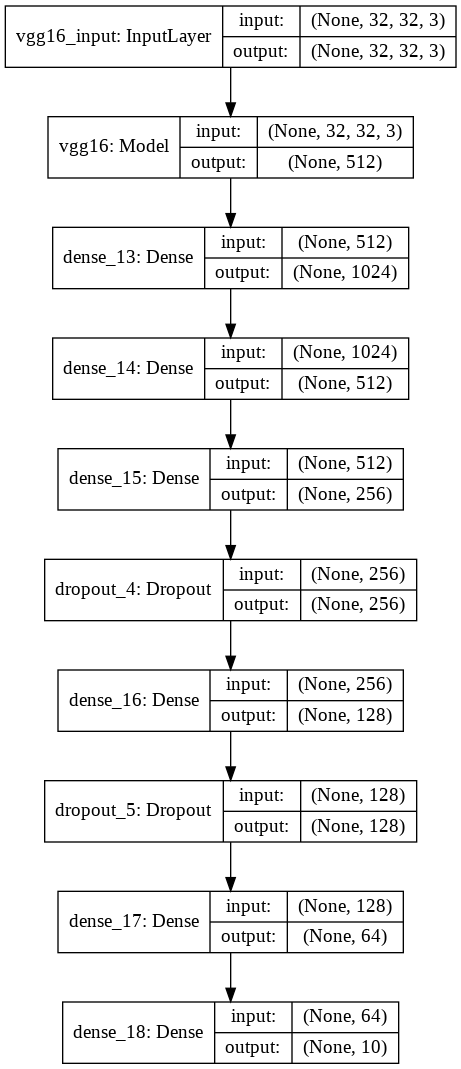

In [59]:
from keras.utils.vis_utils import plot_model
plot_model(custom_model_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)